In [25]:
#@title Github Integration

from google.colab import drive

#@markdown This will prompt you for Google Drive authentication
drive.mount('/content/drive')

# See https://stackoverflow.com/questions/48350226#answer-49933595
! rm -rf /root/.ssh/*
! mkdir -p /root/.ssh
! cp /content/drive/My\ Drive/varderiv/ssh/* /root/.ssh/
! chmod 700 /root/.ssh

! ssh-keyscan gitlab.com >> /root/.ssh/known_hosts
! chmod 644 /root/.ssh/known_hosts

! git clone git@github.com:thisiscam/varderiv.git
  


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
# gitlab.com:22 SSH-2.0-OpenSSH_7.2p2 Ubuntu-4ubuntu2.8
# gitlab.com:22 SSH-2.0-OpenSSH_7.2p2 Ubuntu-4ubuntu2.8
# gitlab.com:22 SSH-2.0-OpenSSH_7.2p2 Ubuntu-4ubuntu2.8
fatal: destination path 'varderiv' already exists and is not an empty directory.


In [4]:
#@title Imports { form-width: "50%", display-mode: "form"}

!pip install tqdm

import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.environ['XLA_FLAGS'] = '--xla_hlo_profile'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' 
import numpy as onp

import jax
import jax.numpy as np
from jax import jacrev, jacfwd, hessian, jit
from jax.experimental.vectorize import vectorize

import functools
import itertools
import collections
import tqdm

from jax.config import config
config.update("jax_debug_nans", False)

from jax import random as jrandom
key = jrandom.PRNGKey(0)

import jax.tree_util
import jax.lax

import matplotlib.pyplot as plt

# For displaying Mathjax in outputs 
from google.colab.output._publish import javascript
mathjax_url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
javascript(url=mathjax_url)

from multiprocessing.dummy import Pool as ThreadPool

import math

# Data Generation Utilties

In [0]:
#@title Data generation functions { form-width: "50%" }

floatt = np.float32

def default_X_generator(key, dim, N):
  if dim % 2 == 0:
    return jrandom.bernoulli(
        key, p=0.5, shape=(N,)).astype(floatt)
  elif dim % 2 == 1:
    return jrandom.normal(key, shape=(N,))
#   elif dim % 2 == 2:
#     return jrandom.uniform(key, shape=(N,), minval=0, maxval=1)


@functools.lru_cache(maxsize=None)
def data_generator(N, X_dim, 
                   X_generator=default_X_generator, 
                   T_thres_ratio=0.6):
  """HOF for data generation. 
  
  The function is cached so that we avoid potential repeating jits'. 
  """
  @vectorize("(k)->(N,p),(N),(p)")
  def wrapped(key):
    r"""Generates dummy data.

    The generative process works as follow:
      1. Sample beta
      2. Sample X with Xr
      3. Sample T^* for each X
      4. Sample C according to `\frac{\log(u)}{\exp(X \cdot \beta)}` 
          where `u \sim \text{Unif}(0, 1)`
      5. Reorder X by `T = \min(T^*, C)`
    """
    beta = np.arange(1, X_dim + 1, dtype=floatt) / X_dim
    X = []
    for dim in range(X_dim):
      key, subkey = jrandom.split(key)
      X.append(X_generator(subkey, dim, N))
    X = np.dstack(X)
    X = X.reshape((X.shape[1:]))

    key, subkey = jrandom.split(key)
    u = jrandom.uniform(subkey, shape=(N,), minval=0, maxval=1)
    T_star = - np.log(u) / np.exp(X.dot(beta))

    key, subkey = jrandom.split(key)
    scale = 3.5
    C = jrandom.exponential(subkey, shape=(N, )) * scale
    delta = T_star <= C

    T = np.minimum(T_star, C)

    sorted_idx = np.argsort(-T) # sort T descending

    T = np.take(T, sorted_idx, axis=0)
    X = np.take(X, sorted_idx, axis=0)
    delta = np.take(delta, sorted_idx, axis=0)
    return X, delta, beta
  return wrapped


@functools.lru_cache(maxsize=None)
def group_labels_generator(N, K, group_labels_generator_kind="random", **kwargs):
  # Validate arguments
  if group_labels_generator_kind in {"random", "same"}:
    assert kwargs == {}
  elif group_labels_generator_kind == "arithmetic_sequence":
    assert kwargs.keys() == {"start_val"}
  elif group_labels_generator_kind == "single_ladder":
    assert kwargs.keys() == {"start_val", "repeat_start"}
  
  @vectorize("(k)->(N)")
  def generate_group_labels(key):
    if group_labels_generator_kind == "random":
      key, subkey = jrandom.split(key)
      group_labels = jrandom.randint(
          subkey, (N, ), minval=0, maxval=K)
      return group_labels
    elif group_labels_generator_kind == "same":
      group_labels = np.arange(N) % K
      group_labels = jrandom.shuffle(key, group_labels)
      return group_labels
    elif group_labels_generator_kind == "arithmetic_sequence":
      start_val = kwargs["start_val"]
      step = int(math.floor(2 * (N - start_val * K) / ((K - 1) * K)))
      end_val = start_val + (K-1) * step
      group_sizes = onp.arange(start_val, end_val+1, step)
      current_total = (start_val + end_val) * K // 2
      residual = N - current_total
      group_sizes[-residual:] += 1
      group_labels = onp.repeat(onp.arange(K), group_sizes)
      group_labels = jrandom.shuffle(key, group_labels)
      return group_labels
    elif group_label_generator_kind == "single_ladder":
      start_val = kwargs["start_val"]
      repeat_start = kwargs["repeat_start"]
      assert 1 <= repeat_start <= K - 1
      rest_val = int(math.floor((N - start_val * repeat_start) 
                                / (K - repeat_start)))
      group_sizes = onp.array([start_val] * repeat_start + 
                              [rest_val] * (K - repeat_start))
      current_total = onp.sum(group_sizes)
      residual = N - current_total
      group_sizes[-residual:] += 1
      group_labels = onp.repeat(onp.arange(K), group_sizes)
      group_labels = jrandom.shuffle(key, group_labels)
      return group_labels
    else:
      raise TypeError("Invalid group_label_generator_kind")

  return generate_group_labels


def group_labels_to_indices(K, group_labels):
    group_labels = onp.array(group_labels)
    batch_mode = True
    if len(group_labels.shape) == 1:
      batch_mode = False
      group_labels = group_labels.reshape((1, -1))
    
    assert len(group_labels.shape) == 2
    #TODO(camyang) make this more efficient?
    ret = [[onp.flatnonzero(gl == k) 
            for k in range(K)] 
           for gl in group_labels]
    if not batch_mode:
      return ret[0]
    return ret


@functools.partial(jit, static_argnums=(0, 1))
def group_data_by_labels(batch_size, K, X, delta, group_indices):
  """Given data group indices, compute groupped data by padding.
  
  Args:
    - batch_size: length of a batch of X
    - K: number of groups
    - X: array of shape (batch_size, N, P).
    - delta: array of shape (batch_size, N)
    - group_indices: nested list of shape (batch_size, K); each list element is
      a flattened array representing indices in a group
  
  Returns:
    tuple of X_groups, delta_groups
    - X_groups: array of shape (batch_size, K, group_size, P)
    - delta_groups: array of shape (batch_size, K, group_size)
  """
  batch_mode = True
  if batch_size <= 1 and len(X.shape) == 2:
    batch_mode = False
    X = X.reshape((1, ) + X.shape)
    delta = delta.reshape((1, ) + delta.shape)
    group_indices = [group_indices]    
  
  batch_size = X.shape[0]
  padded_group_size = max(*[len(group_indices[i][k]) 
                            for k in range(K) 
                            for i in range(batch_size)])

  all_X_groups, all_delta_groups = [], []
  for i in range(batch_size):
    X_groups, delta_groups = [], []
    for k in range(K):
      group_idxs = group_indices[i][k]

      X_group = np.take(X[i], group_idxs, axis=0)
      X_group = np.pad(X_group, 
                       [(0, padded_group_size - X_group.shape[0]), (0, 0)])

      delta_group = np.take(delta[i], group_idxs, axis=0)
      delta_group = np.pad(delta_group, 
                           (0, padded_group_size - delta_group.shape[0],))

      X_groups.append(X_group)
      delta_groups.append(delta_group)
    all_X_groups.append(X_groups)
    all_delta_groups.append(delta_groups)
  
  all_X_groups = np.array(all_X_groups)
  all_delta_groups = np.array(all_delta_groups)
  
  if not batch_mode:
    all_X_groups = all_X_groups.reshape(all_X_groups.shape[1:])
    all_delta_groups = all_delta_groups.reshape(all_delta_groups.shape[1:])
  
  return all_X_groups, all_delta_groups

In [0]:
#@title Parameter definitions and data generation { form-width: "50%" }

N = 300              #@param {type:"integer"}
X_DIM = 2              #@param {type: "integer"}
K = 3                 #@param {type: "integer"}

#@title Generate data { form-width: "50%" }

key, subkey = jrandom.split(key)
X, delta, beta = data_generator(N, X_DIM)(subkey)

# Only create group_labels once
try:
  assert len(group_labels) == N
  assert max(group_labels) == K - 1
except:
  key, subkey = jrandom.split(key)
  group_labels = group_labels_generator(N, K, "random")(subkey)

group_indices = group_labels_to_indices(K, group_labels)
X_groups, delta_groups = group_data_by_labels(1, K, X, delta, group_indices)

# Split out new data generation key
key, data_generation_key = jrandom.split(key)

# Solver

In [0]:
#@title Newton Method for finding multivariate roots for system of equations { form-width: "50%" }

NewtonSolverState = collections.namedtuple(
    "NewtonSolverState", "guess value step"
)

def solve_newton(fn, 
                 key,
                 initial_guess, 
                 norm_stop_thres=1e-3, 
                 jac_mode='forward',
                 max_reset_steps=20,
                 max_num_steps=1000):
  if jac_mode == 'forward':
    jac_fn = jacfwd(fn, 0)
  else:
    jac_fn = jacrev(fn, 0)

  guess = initial_guess
  initial_value = fn(initial_guess)
  
  InternalState = collections.namedtuple(
      "InternalState", "guess value step key")
  
  def newton_update(state: InternalState):
    
    def reset(state: InternalState):
      key, subkey = jrandom.split(state.key, 2)
      guess = initial_guess + jrandom.normal(subkey, 
                                             shape=initial_guess.shape)
      value = fn(guess)
      return InternalState(guess, value, step + 1, key)
    
    def update(state: InternalState):
      guess, value, step, key = state
      jacobian = jac_fn(guess)
      guess = guess - np.linalg.solve(jacobian, value)
      value = fn(guess)
      return InternalState(guess, value, step + 1, key)
    
    step = state.step
    return jax.lax.cond(
        ((step + 1) % max_reset_steps == 0),
        state, reset, 
        state, update)

  def stop_cond(state):
    return np.logical_and(state.step < max_num_steps, 
            np.linalg.norm(state.value, ord=np.inf) > norm_stop_thres)

  ret = jax.lax.while_loop(
      stop_cond,
      newton_update,
      InternalState(initial_guess, initial_value, 0, key)
  )
  
  return NewtonSolverState(ret.guess, ret.value, ret.step)

solve_newton_jit = jit(solve_newton)

## Equation 1



$$
\sum_{j=1}^d 
\Big\{X_{i(j)} - 
  \frac{
    \sum_{l \in R_j} X_l \exp(\beta' X_l)
   }{
    \sum_{l \in R_j} \exp(\beta' X_l)
   } \Big\}
= 0
$$

In [0]:
#@title Eq 1 { form-width: "50%" }


@vectorize('(N,p),(N),(p)->(p)')
def eq1_log_likelihood(X, delta, beta):
  bx = np.einsum("i,bi->b", beta, X)
  ebx_cs = np.cumsum(np.exp(bx), 0)
  log_term = np.log(ebx_cs)
  log_likelhihood = np.sum((bx - log_term) * delta, axis=0)
  return log_likelhihood


@vectorize('(N,p),(N),(p)->(p)')
def eq1_log_likelihood_grad_manual(X, delta, beta):
  """Computes eq1.

  Args:
    - X: N by DIM_X matrix representing features for each sample.
        sorted by T.
    - delta: N vector representing a mask (corresponding to each sample in X) 
        for highlighted samples.
    - beta: DIM_X vector
  
  Returns:
    Evaluation of LHS of Eq 1.
  """
  e_beta_X = np.exp(np.einsum("x,bx->b", beta, X)).reshape((-1, 1))
  X_e_beta_X = X * e_beta_X

  e_beta_X_cs = np.cumsum(e_beta_X, axis=0)
  X_e_beta_X_cs = np.cumsum(X_e_beta_X, axis=0)

  sum_inner = (X - X_e_beta_X_cs / e_beta_X_cs) * delta.reshape(-1, 1)
  
  ret = np.sum(sum_inner, axis=0)
  
  return ret


eq1_log_likelihood_grad_ad = vectorize('(N,p),(N),(p)->(p)')(
    jacfwd(eq1_log_likelihood, 2))


def _solve_eq1(key, X, delta, initial_guess, eq1_ll_grad_fn):
  sol = solve_newton(functools.partial(eq1_ll_grad_fn, X, delta), 
                     key,
                     initial_guess)
  return sol


@vectorize("(k),(N,p),(N),(p)->(p)")
def solve_eq1_ad(key, X, delta, initial_guess):
  return _solve_eq1(key, X, delta, initial_guess, 
                    eq1_log_likelihood_grad_ad)


@vectorize("(k),(N,p),(N),(p)->(p)")
def solve_eq1_manual(key, X, delta, initial_guess):
  return _solve_eq1(key, X, delta, initial_guess, 
                    eq1_log_likelihood_grad_manual)


def solve_eq1(key, X, delta, initial_guess=None, use_ad=False):
  if initial_guess is None:
    initial_guess = np.abs(jrandom.randn(key, X.shape[1]))
  if use_ad:
    return solve_eq1_ad(key, X, delta, initial_guess)
  else:
    return solve_eq1_manual(key, X, delta, initial_guess)


In [9]:
#@title Test solve Eq 1 { form-width: "50%" }

key, subkey = jrandom.split(key)
sol = solve_eq1(subkey, X, delta, initial_guess=beta, use_ad=True)

# sol = solve_eq1_ad(np.stack([subkey]*10), 
#                    np.stack([X]*10), 
#                    np.stack([delta]*10), 
#                    np.stack([beta] * 10))

print(sol)
beta_hat = sol.guess

NewtonSolverState(guess=DeviceArray([0.46046504, 0.92162555], dtype=float32), value=DeviceArray([5.0663948e-06, 6.3180923e-06], dtype=float32), step=DeviceArray(2, dtype=int32))


In [10]:
#@title Eq 1 covariance analytical { form-width: "50%" }

eq1_compute_H_ad = vectorize("(N,p),(N),(p)->(p,p)")(
    hessian(eq1_log_likelihood, 2)
)

@vectorize("(N,p),(N),(p)->(p,p)")
def eq1_compute_H_manual(X, delta, beta):
  e_beta_X = np.exp(np.einsum("x,bx->b", beta, X)).reshape((-1, 1))
  X_e_beta_X = X * e_beta_X
  e_beta_X_cs = np.cumsum(e_beta_X, axis=0)
  X_e_beta_X_cs = np.cumsum(X_e_beta_X, axis=0)
  frac_term_inner = X_e_beta_X_cs / e_beta_X_cs

  X_sub_frac_term = X - frac_term_inner
  X_sub_frac_sq = np.einsum(
      "bi,bj->bij", X_sub_frac_term, X_sub_frac_term)

  e_beta_X_mul_X_sub_frac_sq = e_beta_X.reshape((-1, 1, 1)) * X_sub_frac_sq

  num_outer = np.cumsum(e_beta_X_mul_X_sub_frac_sq, axis=0)
  denom_outer = e_beta_X_cs.reshape((-1, 1, 1))

  frac_term_outer = (num_outer / denom_outer) * delta.reshape(-1, 1, 1)

  return -np.sum(frac_term_outer, axis=0)


def eq1_compute_H(X, delta, beta, use_ad=False):
  if use_ad:
    return eq1_compute_H_ad(X, delta, beta)
  else:
    return eq1_compute_H_manual(X, delta, beta)


def _eq1_cov(X, delta, beta, eq1_H_fn):
  return np.linalg.inv(-eq1_H_fn(X, delta, beta))


@vectorize("(N,p),(N),(p)->(p,p)")
def eq1_cov_manual(X, delta, beta):
  return _eq1_cov(X, delta, beta, eq1_compute_H_manual)


@vectorize("(N,p),(N),(p)->(p,p)")
def eq1_cov_ad(X, delta, beta):
  return _eq1_cov(X, delta, beta, eq1_compute_H_ad)


def eq1_cov(X, delta, beta, use_ad=False):
  if use_ad:
    return eq1_cov_ad(X, delta, beta)
  else:
    return eq1_cov_manual(X, delta, beta)


print("old")
print(eq1_cov(X, delta, beta, use_ad=True))
print(eq1_cov(X, delta, beta, use_ad=False))
# print(eq1_cov(X, delta, beta_hat))


print("hessian")
print(eq1_compute_H(X, delta, beta))

# print(eq1_compute_H(X, delta, beta_hat))

print("new")
print(eq1_cov_ad(X, delta, beta))
# print(eq1_cov_ad(X, delta, beta_hat))


old
[[0.01731823 0.00099985]
 [0.00099986 0.00701445]]
[[0.01835171 0.00101093]
 [0.00101093 0.00742731]]
hessian
[[ -54.90249     7.472765]
 [   7.472765 -135.65533 ]]
new
[[0.01731823 0.00099985]
 [0.00099986 0.00701445]]


In [0]:
#@title Variance Experiment Utilities { form-width: "50%" }

import math
import time

def process_params(**params):
  return params


def grouper(iterable, n, fillvalue=None):
    """grouper
    (3, 'abcdefg', 'x') --> ('a','b','c'), ('d','e','f'), ('g','x','x')"""
    return itertools.zip_longest(*[iter(iterable)]*n, fillvalue=fillvalue)


# Common experiment result namedtuples
ExperimentResultItem = collections.namedtuple(
    "ExperimentResultItem", "sol cov")

ExperimentResult = collections.namedtuple(
    "ExperimentResult", "data_generation_key results")


def expand_namedtuples(tup):
  tup_t = type(tup)
  tup_d = tup._asdict()
  num_items = len(tup_d[tup._fields[0]])
  ret = []
  for i in range(num_items):
    ret.append(tup_t(
      **{
          field: values[i]
          for field, values in tup_d.items()
      }
    ))
  return ret


def run_cov_experiment(init_fn,
                       experiment_fn,
                       data_generation_key=data_generation_key,
                       num_experiments=1000,
                       num_threads=8,
                       batch_size=32,
                       experiment_rand_key=key,
                       **experiment_params):
  
  assert batch_size >= 1, "Invalid batch_size"
  
  subkeys = jrandom.split(experiment_rand_key, num_experiments)
  data_generation_subkeys = jrandom.split(data_generation_key, num_experiments)
  data_iterator = list(zip(subkeys, data_generation_subkeys))

  num_batchs = num_experiments // batch_size

  # We fill in some arbitrary key value for the residuals
  data_iterator = grouper(data_iterator, batch_size, 
                          fillvalue=(subkeys[0], subkeys[0]))
  
  init_fn(experiment_params)

  results = []
  with ThreadPool(num_threads) as pool:
    with tqdm.tqdm_notebook(
        desc="Experiments {}".format(experiment_fn.__name__), 
        total=num_experiments) as pbar:
      pbar.update(0)
      time.sleep(1)
      for sol in pool.imap_unordered(functools.partial(experiment_fn, 
                                                **experiment_params), 
                                     data_iterator):
        results += sol
        pbar.update(len(sol))

  # Trim results that are padded
  results = results[:num_experiments]
  
  return ExperimentResult(
      data_generation_key=data_generation_key, results=results)

def plot_cov_experiment(
    result: ExperimentResult, 
    sol_get_beta,
    get_cov_mapping=None):
  """
  Args:
    - result: the experiment result object.
    - A function given a result.sol, returns the beta
    - A dict from str to function. The string represents a key
      to plot the analytical cov. The function returns the cov
      matrices from result.cov.
  """
  if get_cov_mapping is None:
    get_cov_mapping = {"Analytical": lambda cov: cov}

  print("Data generated using master key {}".format(
      result.data_generation_key))
  
  all_covs = collections.OrderedDict()
  
  results = result.results
  
  beta = onp.stack([sol_get_beta(r.sol) for r in results])
  beta_empirical_nan_idxs = onp.any(onp.isnan(beta), axis=1)
  beta = beta[~beta_empirical_nan_idxs]
  print("Cov empirical has {} nans".format(np.sum(beta_empirical_nan_idxs)))
  
  beta_norm = onp.linalg.norm(beta, axis=1)
  beta_norm_median = onp.median(beta_norm, axis=0)
  outlier_betas_idxs = beta_norm > 100 * beta_norm_median
  beta = beta[~outlier_betas_idxs]
  print("Cov empirical has {} outliers".format(
      np.sum(outlier_betas_idxs)))
  
  cov_empirical = onp.cov(beta, rowvar=False)
  all_covs["Empirical"] = cov_empirical

  for analytical_name, get_cov_fn in get_cov_mapping.items():
    cov_analyticals = onp.array([get_cov_fn(r.cov) for r in results])
    cov_analyticals_nan_idxs = onp.any(onp.isnan(
            cov_analyticals.reshape(-1, cov_analyticals.shape[1] ** 2)), axis=1)
    print("Cov {} has {} nans".format(
        analytical_name,
        np.sum(cov_analyticals_nan_idxs)))
    cov_analyticals = cov_analyticals[~cov_analyticals_nan_idxs]
    cov_analytical = onp.mean(cov_analyticals, axis=0) 
    all_covs[analytical_name] = cov_analytical
  
  for name, cov in all_covs.items():
    print(f"{name}:")
    print(cov)

  ncols = 2
  nrows = int(math.ceil(len(all_covs)/ncols))
  fig, axes = plt.subplots(
      nrows=nrows, 
      ncols=ncols, 
      figsize=np.array([ncols, nrows]) * 3.5)

  vmin = min(*[onp.min(cov) for cov in all_covs.values()])
  vmax = max(*[onp.max(cov) for cov in all_covs.values()])
  
  for i, (name, cov) in enumerate(all_covs.items()):
    ax = axes.flat[i]
    ax.set_title(name, pad=20)
    im = ax.matshow(cov, vmin=vmin, vmax=vmax)

  fig.subplots_adjust(right=0.8, hspace=0.5)
  cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
  fig.colorbar(im, cax=cbar_ax)

  plt.show()


In [13]:
#@title Variance Eq 1 Experiment (pt 1.){ form-width: "50%" }

eq1_cov_experiment_params = process_params(
#@markdown Data config
N = 500               #@param {type:"integer"}
,
X_DIM = 2               #@param {type: "integer"}
,
#@markdown Experiment config
num_experiments = 100000  #@param {type: "integer"}
,
num_threads = 2          #@param {type: "integer"}
,
batch_size = 100          #@param {type: "integer"}
,
#@markdown Equation config
solve_eq1_use_ad = True #@param {type: "boolean"}
,
eq1_cov_use_ad = True #@param {type: "boolean"}
)



def cov_experiment_eq1_init(params):
  gen = jit(data_generator(params["N"], params["X_DIM"]))
  params["gen"] = gen
  del params["N"], params["X_DIM"]
  
  if params["solve_eq1_use_ad"]:
    solve_eq1_fn = jit(solve_eq1_ad)
  else:
    solve_eq1_fn = jit(solve_eq1_manual)
  params["solve_eq1_fn"] = solve_eq1_fn
  del params["solve_eq1_use_ad"]
  
  if params["eq1_cov_use_ad"]:
    eq1_cov_fn = jit(eq1_cov_ad)
  else:
    eq1_cov_fn = jit(eq1_cov_manual)
  params["eq1_cov_fn"] = eq1_cov_fn
  del params["eq1_cov_use_ad"]


def cov_experiment_eq1(args, gen=None, solve_eq1_fn=None, eq1_cov_fn=None):
  assert gen is not None
  assert solve_eq1_fn is not None
  assert eq1_cov_fn is not None

  key, data_generation_key = map(np.array, zip(*args))
  X, delta, beta = gen(data_generation_key)
  
  batch_size = X.shape[0]
  
  assert key.shape == data_generation_key.shape
  
  sol = solve_eq1_fn(key, X, delta, beta)
  beta_hat = sol.guess
  sol = expand_namedtuples(
      type(sol)(*map(onp.array, sol))) # release from jax to numpy
  cov = onp.array(eq1_cov_fn(X, delta, beta_hat))
  ret = expand_namedtuples(ExperimentResultItem(sol=sol, cov=cov))
  return ret


eq1_cov_exp_results = run_cov_experiment(
    cov_experiment_eq1_init,
    cov_experiment_eq1,
    data_generation_key=data_generation_key,
    **eq1_cov_experiment_params)

KeyboardInterrupt: ignored

Data generated using master key [4104543539 3483300570]
Cov empirical has 0 nans
Cov empirical has 0 outliers
Cov Analytical has 0 nans
Empirical:
[[0.01093205 0.00083077]
 [0.00083077 0.0042949 ]]
Analytical:
[[0.01083676 0.00080929]
 [0.00080929 0.00425866]]


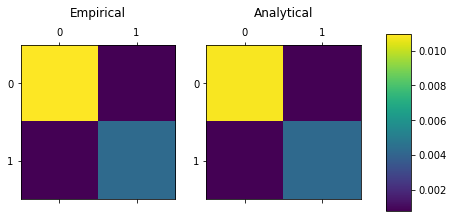

In [81]:
#@title Variance Eq 1 Experiment (pt 2.){ form-width: "50%", vertical-output: true}
  
plot_cov_experiment(eq1_cov_exp_results, lambda sol: sol.guess)

## Equation 2

$$
\sum_{k=1}^{K} 
  \big\{ X_{i(j)} \big\} 
  -
\sum_{j=1}^{d}
\sum_{k=1}^{K} 
   \frac{
    \sum_{l \in R_j(k)} X_l \exp(\hat{\beta'}_k X_l) + 
    \big\{
      \sum_{l \in R_j(k)} X_l X_l' \exp(\hat{\beta'}_k X_l) 
    \big\}' (\beta - \hat{\beta'}_k) 
  }{
    \sum_{l \in R_j(k)} \exp(\hat{\beta'}_k X_l) + 
    \big\{
      \sum_{l \in R_j(k)} X_l \exp(\hat{\beta'}_k X_l) 
    \big\}' (\beta - \hat{\beta'}_k) 
  }
= 0
$$

In [0]:
#@title Eq 2 { form-width: "50%" }

precomputed_signature = "(N,c),(N,p),(N,p,p),(N,c),(N,p),(N,p)"

XX_e_beta_X_path_info_cache = None

@vectorize(f"(N,p),(N),(k,p)->{precomputed_signature}")
def _precompute_eq2_terms(X, group_labels, beta_k_hat):
  beta_k_hat_grouped = np.take(beta_k_hat, group_labels, axis=0)

  beta_k_hat_X = np.einsum("bi,bi->b", X, beta_k_hat_grouped)
  e_beta_k_hat_X = np.exp(beta_k_hat_X).reshape((-1, 1))
  X_e_beta_k_hat_X = X * e_beta_k_hat_X
  
  global XX_e_beta_X_path_info_cache
  if XX_e_beta_X_path_info_cache is None:
    XX_e_beta_X_path_info_cache = np.einsum_path(
    'bi,bj,bk->bij', X, X, e_beta_k_hat_X, optimize='optimal')
  XX_e_beta_k_hat_X = np.einsum('bi,bj,bk->bij', X, X, e_beta_k_hat_X, 
                          optimize=XX_e_beta_X_path_info_cache[0])
  
  e_beta_k_hat_X_cs = np.cumsum(e_beta_k_hat_X, 0)
  X_e_beta_k_hat_X_cs = np.cumsum(X_e_beta_k_hat_X, 0)
  return e_beta_k_hat_X, X_e_beta_k_hat_X, XX_e_beta_k_hat_X, \
    e_beta_k_hat_X_cs, X_e_beta_k_hat_X_cs, beta_k_hat_grouped


@vectorize(f"(N,p),(N),{precomputed_signature},(p)->(N,p)")
def compute_W(X, 
              delta, 
              e_beta_k_hat_X, 
              X_e_beta_k_hat_X, 
              XX_e_beta_k_hat_X, 
              e_beta_k_hat_X_cs, 
              X_e_beta_k_hat_X_cs, 
              beta_k_hat_grouped, 
              beta):
  beta_sub_beta_k_hat = beta - beta_k_hat_grouped
  xxebxbmb = np.einsum("bij,bj->bi", 
                       XX_e_beta_k_hat_X, beta_sub_beta_k_hat)

  xebxbmb = np.einsum("bi,bi->b", 
                      X_e_beta_k_hat_X, beta_sub_beta_k_hat)
  xxebxbmb_cs = np.cumsum(xxebxbmb, 0)
  xebxbmb_cs = np.cumsum(xebxbmb, 0).reshape((-1, 1))

  W = X - (
      (X_e_beta_k_hat_X_cs + xxebxbmb_cs) / (e_beta_k_hat_X_cs + xebxbmb_cs))
  return W


@vectorize(f"(N,p),(N),{precomputed_signature},(p)->(p)")
def eq2_rest(X, 
             delta, 
             e_beta_k_hat_X, 
             X_e_beta_k_hat_X, 
             XX_e_beta_k_hat_X, 
             e_beta_k_hat_X_cs, 
             X_e_beta_k_hat_X_cs, 
             beta_k_hat_grouped, 
             beta):
  W = compute_W(X, delta, 
                e_beta_k_hat_X, 
                X_e_beta_k_hat_X, 
                XX_e_beta_k_hat_X, 
                e_beta_k_hat_X_cs, 
                X_e_beta_k_hat_X_cs, 
                beta_k_hat_grouped, 
                beta)
  return np.sum(W * delta.reshape((-1, 1)), axis=0)


def eq2_jac_manual(X, delta, group_labels, beta_k_hat, beta):
    precomputed = _precompute_eq2_terms(X, group_labels, beta_k_hat)
    return eq2_rest(X, delta, *precomputed, beta)

  
def _eq2_solve_rest(key, X, delta, K, group_labels, 
                    X_groups, delta_groups, 
                    beta_k_hat, beta_guess):
  
  del X_groups, delta_groups
  
  precomputed = _precompute_eq2_terms(X, group_labels, beta_k_hat)
  
  @vectorize(f"(k),(N,p),(N),{precomputed_signature},(p)->(p)")
  def _solve(key, X, delta, 
             e_beta_k_hat_X, 
             X_e_beta_k_hat_X, 
             XX_e_beta_k_hat_X, 
             e_beta_k_hat_X_cs, 
             X_e_beta_k_hat_X_cs, 
             beta_k_hat_grouped,
             beta_guess):
    return solve_newton(
        functools.partial(
            eq2_rest, 
            X, delta, 
            e_beta_k_hat_X, 
            X_e_beta_k_hat_X, 
            XX_e_beta_k_hat_X, 
            e_beta_k_hat_X_cs, 
            X_e_beta_k_hat_X_cs, 
            beta_k_hat_grouped
        ), 
        key,
        beta_guess)
  
  return _solve(key, X, delta, *precomputed, beta_guess)


def _solve_grouped_eq_batch(key, X, delta, K, group_labels, 
                            X_groups=None, delta_groups=None,
                            initial_guess=None, 
                            solve_eq1_fn=solve_eq1_manual,
                            solve_rest_fn=_eq2_solve_rest,
                            log=False,
                            log_solve_rest_name="Eq2"):
  """Common function used by Equation 2 and 4.
  
  This function is done in few stages:
    1. Arguments are tested to see if we are in batch mode, if not, necessary
      arguments are turn batch of size 1.
    2. A single group_size is decided over all batch and all groups. All groups
      are padded and converted; then a single solve_eq_fn is invoked to solve
      for all groups at the same time.
    3. solve_rest is invoked across batch and result is returned.
    
  Note that this function DOES NOT perform any jitting. For one, groupping data
  cannot be jitt'ed currently in jax. User is responsible for passing in jitt'ed
  versions of `solve_eq1_fn` and `solve_rest_fn` if desirable. 
  
  Returns:
    beta_k_hat: solved K groups of beta_k_hat, 
    beta: final solution beta
  """
  
  if len(X.shape) == 2:
    # We are not in batch mode
    assert len(delta.shape) == 1
    assert len(group_labels.shape) == 1
    X = X.reshape((1, ) + X.shape)
    delta = delta.reshape((1, ) + delta.shape)
    group_labels = group_labels.reshape((1, ) + group_labels.shape)
    initial_guess = initial_guess.reshape((1, ) + initial_guess.shape)
  assert len(X.shape) == 3

  batch_size = X.shape[0]
  X_dim = X.shape[-1]
  
  if initial_guess is None:
    initial_guess = np.abs(jrandom.normal(key, shape=(batch_size, X_dim)))

  assert initial_guess.shape == (batch_size, X_dim)

  step_1_initial_guess = np.broadcast_to(initial_guess, 
                                         (K, batch_size, X_dim))
  step_1_initial_guess = np.transpose(step_1_initial_guess, axes=[1, 0, 2])
  assert step_1_initial_guess.shape == (batch_size, K, X_dim)
  
  if X_groups is None or delta_groups is None:
    group_indices = group_labels_to_indices(K, group_labels)
    X_groups, delta_groups = group_data_by_labels(
        batch_size, K, X, delta, group_indices)
  
  group_size = delta_groups.shape[-1]
  assert X_groups.shape == (batch_size, K, group_size, X_dim)
  assert delta_groups.shape == (batch_size, K, group_size)
  
  sols = solve_eq1_fn(np.broadcast_to(key, (K,) + key.shape)
                      .reshape((batch_size, K, key.shape[-1])), 
                      X_groups, delta_groups, step_1_initial_guess)
  if log:
    for i, sol_single_batch in enumerate(zip(sols.guess, sols.value, sols.step)):
        for k, (beta, value, step) in enumerate(zip(*sol_single_batch)):
          print("batch {} solved Eq1 for group {} beta={} value={} in {} steps"
                .format(i, k, beta, value, step))

  beta_k_hat = sols.guess
  
  beta, value, steps = solve_rest_fn(
      key, X, delta, K, group_labels, X_groups, delta_groups, beta_k_hat, 
      initial_guess)
 
  if log:
    print("Solved {} beta={} value={} in {} steps".format(
        log_solve_rest_name, beta, value, steps))
  
  return beta_k_hat, beta



solve_eq2 = functools.partial(_solve_grouped_eq_batch, 
                              solve_rest_fn=_eq2_solve_rest)

In [83]:
#@title Test solve Eq 2 { form-width: "50%" }

key, subkey = jrandom.split(key)
beta_k_hat, beta_hat = solve_eq2(
    key, X, delta, K, group_labels, 
    initial_guess=beta, log=True)

batch 0 solved Eq1 for group 0 beta=[0.3490241 0.9085475] value=[3.3795834e-05 4.5478344e-05] in 2 steps
batch 0 solved Eq1 for group 1 beta=[0.6475832 1.0185529] value=[4.1723251e-07 5.6624413e-06] in 2 steps
batch 0 solved Eq1 for group 2 beta=[0.45712268 0.9273113 ] value=[2.3841858e-06 2.3782253e-05] in 2 steps
Solved Eq2 beta=[[0.4686165 0.9254763]] value=[[6.484985e-05 6.904602e-04]] in [2] steps


Eq 2 covariance analytical

$$
\begin{align}
A = \sum_{k=1}^{K} 
\end{align}
$$

In [84]:
#@title Eq 2 covariance analytical { form-width: "50%" }


# Take gradient with respect to beta and beta_k_hat
eq2_compute_I_row = jacfwd(eq2_jac_manual, (-2, -1))


def eq2_compute_I_row_wrapped(X, delta,
                              X_groups, 
                              delta_groups, 
                              group_labels, 
                              beta_k_hat, beta):
  return eq2_compute_I_row(X, delta, group_labels, beta_k_hat, beta)


def _cov_beta_k_correction(
    compute_I_row_wrapped_fn,
    X, delta, 
    X_groups, delta_groups, 
    group_labels, 
    beta_k_hat, beta):
  """Computes Eq 2 cov with beta_k correction.
  
  Computes hessian using AD, then adjust with beta_k variances.
  This function is not vectorized itself.
  
  Args:
    - compute_I_row_wrapped_fn: a *vectorized* function that computes the last
      row in I matrix.
  """

  I_diag_wo_last = -eq1_compute_H(X_groups, delta_groups, beta_k_hat)
  
  I_row, I_diag_last = compute_I_row_wrapped_fn(
      X, delta, X_groups, delta_groups, group_labels, beta_k_hat, beta)
  I_row, I_diag_last = -I_row, -I_diag_last
  
  cov = _eq2_cov_pure_analytical_from_I(
      I_diag_wo_last,
      I_diag_last,
      I_row)
  return cov


@vectorize("(k,p,p),(p,p),(p,k,p)->(p,p)")
def _eq2_cov_pure_analytical_from_I(
    I_diag_wo_last, 
    I_diag_last,
    I_row):
  """
  Args:
    - I_diag_wo_last: array of shape (K, P, P)
    - I_diag_last: array of shape (P, P)
    - I_row: array of shape (P, K, P)
  """
  I_row = np.moveaxis(I_row, 1, 0)

  I_diag_inv_last = np.linalg.inv(I_diag_last)
  I_diag_inv_wo_last = np.linalg.inv(I_diag_wo_last)
  
  cov = np.einsum(
      "ab,Bbc,Bcd,Bed,fe->af",
      I_diag_inv_last,
      I_row,
      I_diag_inv_wo_last,
      I_row,
      I_diag_inv_last
  ) + I_diag_inv_last

  return cov


eq2_cov_beta_k_correction = vectorize(
    "(N,p),(N),(k,s,p),(k,s),(N),(k,p),(p)->(p,p)")(
    functools.partial(
        _cov_beta_k_correction, eq2_compute_I_row_wrapped)
)


eq2_compute_H = jacfwd(eq2_jac_manual, -1)
 

@vectorize("(N,p),(N),(N),(k,p),(p)->(p,p)")
def eq2_cov_robust_ad_impl(
    X, delta, group_labels, beta_k_hat, beta):
  """Computes covariance for eq2 with AD jacobian.
  
  Not really robust! Name from `Robust Estimate`.
  Uses AD to computes Hessian of equation 2, then return
                `H^-1 J H^-1`
  """
  # TODO(camyang) this is not optimized
  
  precomputed = _precompute_eq2_terms(X, group_labels, beta_k_hat)
   
  H = eq2_compute_H(X, delta, group_labels, beta_k_hat, beta)
  
  # compute J
  W = compute_W(X, delta, *precomputed, beta)
  W2 = np.einsum("bi,bj->bij", W, W)
  J = np.sum(W2 * delta.reshape((-1, 1, 1)), axis=0)
  
  H_inv = np.linalg.inv(H)
  ret =  (-H_inv) @ J @ (-H_inv)
  
  return -H_inv, ret


def eq2_cov_robust_ad(X, delta, 
                      X_groups, delta_groups, 
                      group_labels, 
                      beta_k_hat, beta):
  
  del X_groups, delta_groups
  
  ret = eq2_cov_robust_ad_impl(X, delta, group_labels, beta_k_hat, beta)
  
  return ret[1]


  
# by default, we use analytical with beta_k correction
eq2_cov = eq2_cov_beta_k_correction

print(beta, beta_hat)
print(eq2_cov(X, delta,
              X_groups, delta_groups, 
              group_labels, 
              beta_k_hat, beta_hat))

[0.5 1. ] [[0.4686165 0.9254763]]
[[[0.01723571 0.00115707]
  [0.0009416  0.00685901]]]


In [86]:
#@title Variance Eq 2 Experiment (pt 1.){ form-width: "50%" }


eq2_cov_experiment_params = process_params(
#@markdown Data config
N = 500               #@param {type:"integer"}
,
X_DIM = 2               #@param {type: "integer"}
,
K = 3                   #@param {type: "integer"}
,
#@markdown Group config
group_labels_generator_kind = "same" #@param ["random", "same", "arithmetic_sequence", "single_ladder"]
,
group_labels_generator_kind_kwargs = {} #@param
,
#@markdown Experiment config
num_experiments = 100000  #@param {type: "integer"}
,
num_threads = 1          #@param {type: "integer"}
,
batch_size = 100          #@param {type: "integer"}
,
#@markdown Equation config
solve_eq1_use_ad = True #@param {type: "boolean"}
)


Experiment2SolResult = collections.namedtuple(
    "Experiment2SolResult", "beta_k_hat beta_hat")

Experiment2CovResult = collections.namedtuple(
    "Experiment2CovResult", "cov_beta_k_correction cov_robust_ad cov_H")


def cov_experiment_eq2_init(params):
  params["group_labels_gen"] = jit(
      group_labels_generator(
          params["N"], 
          params["K"],
          group_labels_generator_kind=params["group_labels_generator_kind"],
          **params["group_labels_generator_kind_kwargs"]
  ))
  del params["group_labels_generator_kind"]
  del params["group_labels_generator_kind_kwargs"]
  
  gen = jit(data_generator(params["N"], params["X_DIM"]))
  params["gen"] = gen
  
  if params["solve_eq1_use_ad"]:
    solve_eq1_fn = solve_eq1_ad
  else:
    solve_eq1_fn = solve_eq1_manual
  solve_eq2 = functools.partial(_solve_grouped_eq_batch, 
                                solve_eq1_fn=jit(solve_eq1_fn),
                                solve_rest_fn=jit(_eq2_solve_rest))
  params["solve_eq2_fn"] = solve_eq2
  del params["solve_eq1_use_ad"]
  
  params["cov_beta_k_correction_fn"] = jit(eq2_cov_beta_k_correction)
  params["cov_robust_fn"] = jit(eq2_cov_robust_ad_impl)

  
def cov_experiment_eq2(rnd_keys, N=1000, X_DIM=4, K=3, 
                       gen=None,
                       group_labels_gen=None,
                       solve_eq2_fn=None,
                       cov_beta_k_correction_fn=None,
                       cov_robust_fn=None):
  assert gen is not None
  assert group_labels_gen is not None
  assert solve_eq2_fn is not None
  assert cov_beta_k_correction_fn is not None
  assert cov_robust_fn is not None

  key, data_generation_key = map(np.array, zip(*rnd_keys))
  
  X, delta, beta = gen(data_generation_key)
  group_labels = group_labels_gen(data_generation_key)
  
  batch_size = len(X)
  assert beta.shape == (batch_size, X_DIM)

  group_indices = group_labels_to_indices(K, group_labels)
  X_groups, delta_groups = group_data_by_labels(
      batch_size, K, X, delta, group_indices)

  beta_k_hat, beta_hat = solve_eq2_fn(
      key, X, delta, K, group_labels,
      X_groups=X_groups, delta_groups=delta_groups,
      initial_guess=beta, 
      log=False)
  
  cov_beta_k_correction = cov_beta_k_correction_fn(
      X, delta, 
      X_groups, delta_groups, 
      group_labels, 
      beta_k_hat, beta_hat)
  cov_beta_k_correction = onp.array(cov_beta_k_correction)
  
  cov_H, cov_robust_ad = cov_robust_fn(
      X, delta, group_labels, beta_k_hat, beta)
  cov_H = onp.array(cov_H)
  cov_robust_ad = onp.array(cov_robust_ad)
  
  beta_k_hat = onp.array(beta_k_hat)
  beta_hat = onp.array(beta_hat)
  
  ret = expand_namedtuples(ExperimentResultItem(
      sol=expand_namedtuples(Experiment2SolResult(
          beta_k_hat=beta_k_hat, 
          beta_hat=beta_hat
      )), 
      cov=expand_namedtuples(Experiment2CovResult(
          cov_beta_k_correction=cov_beta_k_correction,
          cov_robust_ad=cov_robust_ad,
          cov_H=cov_H
      ))))
  return ret


eq2_cov_exp_results = run_cov_experiment(
    cov_experiment_eq2_init,
    cov_experiment_eq2,
    data_generation_key=data_generation_key,
    **eq2_cov_experiment_params)

KeyboardInterrupt: ignored

Data generated using master key [4104543539 3483300570]
Cov empirical has 0 nans
Cov empirical has 0 outliers
(array([], dtype=int64),)
Cov H^-1 est has 0 nans
(array([], dtype=int64),)
Cov Robust has 0 nans
(array([], dtype=int64),)
Cov Beta_k correction has 0 nans
Empirical:
[[0.01130047 0.00091743]
 [0.00091743 0.00449991]]
H^-1 est:
[[0.01048395 0.00073294]
 [0.00069965 0.004084  ]]
Robust:
[[0.01039089 0.00070176]
 [0.0006243  0.00401415]]
Beta_k correction:
[[0.01172324 0.00118724]
 [0.00117646 0.00468336]]


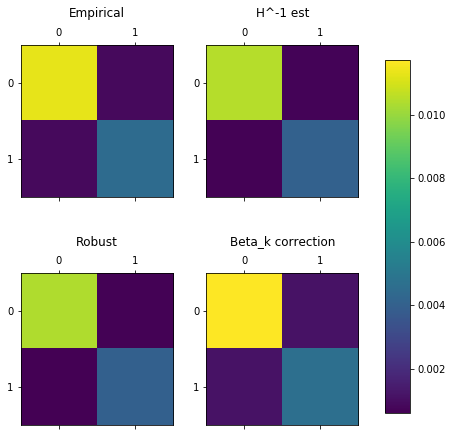

In [64]:
#@title Variance Eq 2 Experiment (pt 2.){ form-width: "50%", vertical-output: true}

plot_cov_experiment(
    eq2_cov_exp_results, 
    lambda sol: sol[1],
    {
        "H^-1 est": 
          lambda cov: cov.cov_H,
        "Robust": 
          lambda cov: cov.cov_robust_ad,
        "Beta_k correction": 
          lambda cov: cov.cov_beta_k_correction
    }
)

# Case 2

## Equation 3

In [0]:
#@title Eq 3 { form-width: "50%"}


def eq3_log_likelihood_grad(eq1_ll_grad_fn, X_groups, delta_groups, beta):
  return np.sum(
      eq1_ll_grad_fn(X_groups, 
                     delta_groups, 
                     np.broadcast_to(beta, 
                                     (X_groups.shape[0], ) + beta.shape)),
      axis=(0, )
  )


@functools.lru_cache(maxsize=None)
def eq3_solver(eq1_log_likelihood_grad_fn):
  @vectorize("(k),(K,N,p),(K,N),(p)->(p)")
  def wrapped(key, X_groups, delta_groups, initial_guess):
    return solve_newton(
        functools.partial(eq3_log_likelihood_grad, 
                          eq1_log_likelihood_grad_fn, 
                          X_groups, delta_groups),
        key,
        initial_guess
    )
  return wrapped


def solve_eq3(key, X, delta, K, group_labels, 
              X_groups=None, delta_groups=None,
              initial_guess=None, 
              eq1_use_ad=False):
  """Solves equation 3, NOT batched."""
  
  if initial_guess is None:
    initial_guess = np.abs(jrandom.normal(key, shape=(X.shape[-1],)))

  if X_groups is None or delta_groups is None:
    group_indices = group_labels_to_indices(K, group_labels)
    X_groups, delta_groups = group_data_by_labels(
        1, K, X, delta, group_indices)
  
  if eq1_use_ad:
    eq1_ll_grad_fn = eq1_log_likelihood_grad_manual
  else:
    eq1_ll_grad_fn = eq1_log_likelihood_grad_ad
  
  sol = eq3_solver(eq1_ll_grad_fn)(key, X_groups, delta_groups, initial_guess)
  
  return sol


In [88]:
#@title Test solve Eq 3 { form-width: "50%"}

key, subkey = jrandom.split(key)
sol = solve_eq3(subkey, X, delta, K, group_labels,
                initial_guess=beta, 
                eq1_use_ad=True)

print(sol)
beta_hat = sol.guess

NewtonSolverState(guess=DeviceArray([0.47727022, 0.94596571], dtype=float32), value=DeviceArray([1.43051147e-06, 1.04904175e-05], dtype=float32), step=DeviceArray(2, dtype=int32))


In [93]:
#@title Eq 3 covariance { form-width: "50%"}

eq3_compute_H = jacfwd(eq3_log_likelihood_grad, -1)

@functools.lru_cache(maxsize=None)
def get_eq3_cov_fn(eq1_ll_grad_fn):
  @vectorize("(K,N,p),(K,N),(p)->(p,p)")
  def wrapped(X_groups, delta_groups, beta):
    H = eq3_compute_H(eq1_ll_grad_fn, X_groups, delta_groups, beta)
    return np.linalg.inv(-H)
  return wrapped

get_eq3_cov_fn(eq1_log_likelihood_grad_ad)(X_groups, delta_groups, beta)

DeviceArray([[0.01797513, 0.00121938],
             [0.00121938, 0.00737118]], dtype=float32)

In [94]:
#@title Variance Eq3 Experiment (pt 1.) { form-width: "50%"}


eq3_cov_experiment_params = process_params(
#@markdown Data config
N = 500               #@param {type:"integer"}
,
X_DIM = 2               #@param {type: "integer"}
,
K = 3                   #@param {type: "integer"}
,
#@markdown Group config
group_labels_generator_kind = "same" #@param ["random", "same", "arithmetic_sequence", "single_ladder"]
,
group_labels_generator_kind_kwargs = {} #@param
,
#@markdown Experiment config
num_experiments = 100000  #@param {type: "integer"}
,
num_threads = 1          #@param {type: "integer"}
,
batch_size = 100          #@param {type: "integer"}
,
#@markdown Equation config
eq1_ll_grad_use_ad = True      #@param {type: "boolean"}
)


def cov_experiment_eq3_init(params):
  params["group_labels_gen"] = jit(
      group_labels_generator(
          params["N"], 
          params["K"],
          group_labels_generator_kind=params["group_labels_generator_kind"],
          **params["group_labels_generator_kind_kwargs"]
  ))
  del params["group_labels_generator_kind"]
  del params["group_labels_generator_kind_kwargs"]

  gen = jit(data_generator(params["N"], params["X_DIM"]))
  params["gen"] = gen
  
  if params["eq1_ll_grad_use_ad"]:
    eq1_ll_grad_fn = eq1_log_likelihood_grad_ad
  else:
    eq1_ll_grad_fn = eq1_log_likelihood_grad_manual
  solve_eq3_fn = jit(eq3_solver(eq1_ll_grad_fn))
  eq3_cov_fn = jit(get_eq3_cov_fn(eq1_ll_grad_fn))
  
  params["solve_eq3_fn"] = solve_eq3_fn
  params["eq3_cov_fn"] = eq3_cov_fn
  del params["eq1_ll_grad_use_ad"]

  
def cov_experiment_eq3(rnd_keys, N=1000, X_DIM=4, K=3, 
                       gen=None,
                       group_labels_gen=None,
                       solve_eq3_fn=None,
                       eq3_cov_fn=None):
  assert gen is not None
  assert group_labels_gen is not None
  assert solve_eq3_fn is not None
  assert eq3_cov_fn is not None

  key, data_generation_key = map(np.array, zip(*rnd_keys))
  
  X, delta, beta = gen(data_generation_key)
  group_labels = group_labels_gen(data_generation_key)
  
  batch_size = len(X)
  
  group_indices = group_labels_to_indices(K, group_labels)
  X_groups, delta_groups = group_data_by_labels(
      batch_size, K, X, delta, group_indices)
  
  sol = solve_eq3_fn(key, X_groups, delta_groups, beta)
  beta_hat = sol.guess
  
  sol = expand_namedtuples(type(sol)(*map(onp.array, sol)))

  cov = onp.array(eq3_cov_fn(X_groups, delta_groups, beta_hat))
  
  ret = expand_namedtuples(ExperimentResultItem(sol=sol, cov=cov))
  return ret

eq3_cov_exp_results = run_cov_experiment(
    cov_experiment_eq3_init,
    cov_experiment_eq3,
    **eq3_cov_experiment_params)


KeyboardInterrupt: ignored

In [164]:
#@title Variance Eq 3 Experiment (pt 2.){ form-width: "50%", vertical-output: true}
  
plot_cov_experiment(eq3_cov_exp_results, lambda sol: sol.guess)

NameError: ignored

## Equation 4

In [0]:
#@title Eq 4 { form-width: "50%"}

@vectorize("(K,S,p),(K,S),(K,p),(p)->(p)")
def eq4(X_groups, delta_groups, beta_k_hat, beta):
  
  K = X_groups.shape[0]
  S = X_groups.shape[1]
  X_dim = X_groups.shape[2]
  
  beta_k_hat_grouped = np.transpose(
      np.broadcast_to(beta_k_hat, (S, K, X_dim)),
      (1, 0, 2)
  )
  
  # All groups are now separarete, then group_labels is 0 for each sample
  group_labels = np.zeros(delta_groups.shape, dtype=np.uint32)

  ret = np.sum(
      eq2_jac_manual(
        X_groups, 
        delta_groups, 
        group_labels, 
        beta_k_hat_grouped, 
        beta),
      axis=0)
  
  return ret


def _eq4_solve_rest(key, 
                    X, delta, K, group_labels, 
                    X_groups, delta_groups, 
                    beta_k_hat, beta_guess):
  del K, X, delta, group_labels
  
  @vectorize(f"(k),(K,N,p),(K,N),(K,p),(p)->(p)")
  def _solve(key, X_groups, delta_groups, beta_k_hat, beta_guess):
      sol = solve_newton(
          functools.partial(eq4, X_groups, delta_groups, beta_k_hat),
          key,
          beta_guess)
      return sol
  
  return _solve(key, X_groups, delta_groups, beta_k_hat, beta_guess)


solve_eq4 = functools.partial(_solve_grouped_eq_batch, 
                              solve_rest_fn=_eq4_solve_rest)

In [96]:
#@title Test solve Eq 4  { form-width: "50%"}

key, subkey = jrandom.split(key)
beta_k_hat, beta_hat = solve_eq4(
    key, X, delta, K, group_labels, 
    initial_guess=beta, log=True)

batch 0 solved Eq1 for group 0 beta=[0.3490241 0.9085475] value=[3.3795834e-05 4.5478344e-05] in 2 steps
batch 0 solved Eq1 for group 1 beta=[0.6475832 1.0185529] value=[4.1723251e-07 5.6624413e-06] in 2 steps
batch 0 solved Eq1 for group 2 beta=[0.45712268 0.9273113 ] value=[2.3841858e-06 2.3782253e-05] in 2 steps
Solved Eq2 beta=[[0.48554206 0.9492715 ]] value=[[5.9604645e-06 8.1062317e-05]] in [2] steps


In [97]:
#@title Eq 4 covariance analytical  { form-width: "50%"}

# Take gradient with respect to beta and beta_k_hat
eq4_compute_I_row = jacfwd(eq4, (-2, -1))

def eq4_compute_I_row_wrapped(X, delta,
                              X_groups, delta_groups, 
                              group_labels, 
                              beta_k_hat, beta):
  return eq4_compute_I_row(X_groups, delta_groups, beta_k_hat, beta)


eq4_cov_beta_k_correction = vectorize(
    "(N,p),(N),(k,s,p),(k,s),(N),(k,p),(p)->(p,p)"
)(
    functools.partial(
        _cov_beta_k_correction, eq4_compute_I_row_wrapped)
)

eq4_cov = eq4_cov_beta_k_correction


print(beta, beta_hat)
print(eq4_cov(X, delta,
              X_groups, delta_groups, 
              group_labels, 
              beta_k_hat, beta_hat))

[0.5 1. ] [[0.48554206 0.9492715 ]]
[[[0.01798259 0.00125519]
  [0.00129002 0.0072472 ]]]


In [100]:
#@title Variance Eq4 Experiment (pt 1.) { form-width: "50%"}


eq4_cov_experiment_params = process_params(
#@markdown Data config
N = 500               #@param {type:"integer"}
,
X_DIM = 2               #@param {type: "integer"}
,
K = 3                   #@param {type: "integer"}
,
#@markdown Group config
group_labels_generator_kind = "same" #@param ["random", "same", "arithmetic_sequence", "single_ladder"]
,
group_labels_generator_kind_kwargs = {} #@param
,
#@markdown Experiment config
num_experiments = 100000  #@param {type: "integer"}
,
num_threads = 1          #@param {type: "integer"}
,
batch_size = 100          #@param {type: "integer"}
,
#@markdown Equation config
solve_eq1_use_ad = True      #@param {type: "boolean"}
)


Experiment4SolResult = collections.namedtuple(
    "Experiment4SolResult", "beta_k_hat beta_hat")


def cov_experiment_eq4_init(params):
  params["group_labels_gen"] = jit(
      group_labels_generator(
          params["N"], 
          params["K"],
          group_labels_generator_kind=params["group_labels_generator_kind"],
          **params["group_labels_generator_kind_kwargs"]
  ))
  del params["group_labels_generator_kind"]
  del params["group_labels_generator_kind_kwargs"]

  gen = jit(data_generator(params["N"], params["X_DIM"]))
  params["gen"] = gen
  
  if params["solve_eq1_use_ad"]:
    solve_eq1_fn = solve_eq1_ad
  else:
    solve_eq1_fn = solve_eq1_manual
  solve_eq4_fn = functools.partial(_solve_grouped_eq_batch, 
                                   solve_eq1_fn=jit(solve_eq1_fn),
                                   solve_rest_fn=jit(_eq4_solve_rest))
  params["solve_eq4_fn"] = solve_eq4_fn
  del params["solve_eq1_use_ad"]
  
  params["cov_beta_k_correction_fn"] = jit(eq4_cov_beta_k_correction)


def cov_experiment_eq4(rnd_keys, N=1000, X_DIM=4, K=3, 
                       gen=None,
                       group_labels_gen=None,
                       solve_eq4_fn=None,
                       cov_beta_k_correction_fn=None):
  assert gen is not None
  assert group_labels_gen is not None
  assert solve_eq4_fn is not None
  assert cov_beta_k_correction_fn is not None

  key, data_generation_key = map(np.array, zip(*rnd_keys))
  
  X, delta, beta = gen(data_generation_key)
  group_labels = group_labels_gen(data_generation_key)
  
  batch_size = len(X)
  assert beta.shape == (batch_size, X_DIM)

  group_indices = group_labels_to_indices(K, group_labels)
  X_groups, delta_groups = group_data_by_labels(
      batch_size, K, X, delta, group_indices)


  beta_k_hat, beta_hat = solve_eq4_fn(
      key, X, delta, K, group_labels,
      X_groups=X_groups, delta_groups=delta_groups,
      initial_guess=beta, 
      log=False)
  
  cov_beta_k_correction = cov_beta_k_correction_fn(
      X, delta, 
      X_groups, delta_groups, 
      group_labels, 
      beta_k_hat, beta_hat)
  cov_beta_k_correction = onp.array(cov_beta_k_correction)
  
  
  beta_k_hat = onp.array(beta_k_hat)
  beta_hat = onp.array(beta_hat)
  
  ret = expand_namedtuples(ExperimentResultItem(
      sol=expand_namedtuples(Experiment4SolResult(
          beta_k_hat=beta_k_hat, 
          beta_hat=beta_hat
      )), 
      cov=cov_beta_k_correction))
  return ret


eq4_cov_exp_results = run_cov_experiment(
    cov_experiment_eq4_init,
    cov_experiment_eq4,
    **eq4_cov_experiment_params)


Data generated using master key [2336434339  995697925]
Cov empirical has 0 nans
Cov Analytical has 0 nans
Empirical:
[[0.01155029 0.00089727]
 [0.00089727 0.00448457]]
Analytical:
[[0.01126056 0.00087747]
 [0.00086404 0.00440215]]


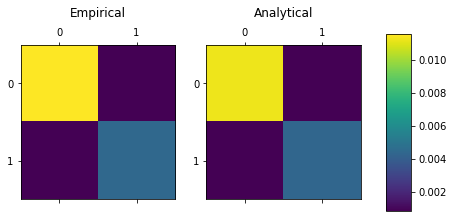

In [142]:
#@title Variance Eq 4 Experiment (pt 2.){ form-width: "50%", vertical-output: true}
  
plot_cov_experiment(eq4_cov_exp_results, lambda sol: sol.beta_hat)

# Full experiments

beta
[0.5074203 1.0273044]
[0.5 1. ]
empirical
[[0.06114544 0.00471935]
 [0.00471935 0.02458272]]
[[0. 0.]
 [0. 0.]]
analytical
[[0.06535791 0.00506978]
 [0.00506978 0.02717258]]
[[nan nan]
 [nan nan]]


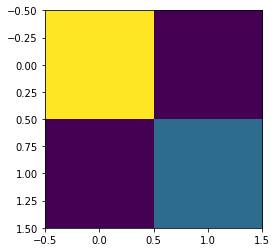

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


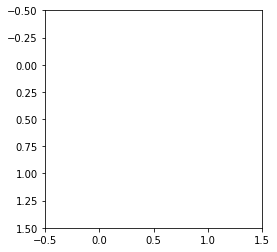

In [0]:
eq1_beta_hats = onp.array([r.sol.guess for r in eq1_cov_exp_results.results])
eq2_beta_hats = onp.array([r.sol[1] for r in eq2_cov_exp_results.results])

print("beta")
print(onp.mean(eq1_beta_hats, axis=0))
print(onp.mean(eq2_beta_hats, axis=0))

print("empirical")
empirical_eq1_cov = onp.cov(eq1_beta_hats, rowvar=False)
empirical_eq2_cov = onp.cov(eq2_beta_hats, rowvar=False)
print(empirical_eq1_cov)
print(empirical_eq2_cov)

print("analytical")
analytical_eq1_cov = onp.mean(
    [r.cov for r in eq1_cov_exp_results.results], axis=0)
analytical_eq2_cov = onp.mean(
    [r.cov for r in eq2_cov_exp_results.results], axis=0)
print(analytical_eq1_cov)
print(analytical_eq2_cov)

plt.imshow(empirical_eq1_cov - empirical_eq2_cov)
plt.show()

plt.imshow(analytical_eq1_cov - analytical_eq2_cov)
plt.show()